# Gabby - Feedforward Neural Network 
Develop a feedforward neural network with sigmoid activation for binary classification to predict Risky Drinking status. Use the cross entropy loss to measure loss. 

### <b>I. Setup</b> 
Load in libraries.

In [15]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow_datasets as tfds


# sklearn
from sklearn import ensemble
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

# plots
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

%matplotlib inline

### <b>II. Prepare data</b> 
Access data and perform pre-processing.

In [2]:
# load data
X_train = pd.read_csv('cleaned_X_train.csv')
y_train = pd.read_csv('cleaned_y_train.csv')['risky_drinking'].values

X_val = pd.read_csv('cleaned_X_val.csv')
y_val = pd.read_csv('cleaned_y_val.csv')['risky_drinking'].values

X_test = pd.read_csv('cleaned_X_test.csv')
y_test = pd.read_csv('cleaned_y_test.csv')['risky_drinking'].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (24158, 24)
X_val shape: (5178, 24)
X_test shape: (5177, 24)


In [3]:
print("Class distribution")
print(f"Risky drinking: {y_train.sum():,} ({y_train.mean():.1%})")
print(f"Not risky: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")

Class distribution
Risky drinking: 9,110 (37.7%)
Not risky: 15,048 (62.3%)


#### Downsample the minority class

In [4]:
minority_indices = np.where(y_train == 1)[0]
majority_indices = np.where(y_train == 0)[0]

# sample from majority class
np.random.seed(RANDOM_SEED)
downsampled_majority_indices = np.random.choice(majority_indices, size=len(minority_indices), replace=False)

# combine indices
balanced_indices = np.concatenate([minority_indices, downsampled_majority_indices])
np.random.shuffle(balanced_indices)

# create balanced training set
X_train_balanced = X_train.iloc[balanced_indices].reset_index(drop=True)
y_train_balanced = y_train[balanced_indices]

### <b>III. Build model</b> 
Implement a feedforward neural network for tabular data, using sigmoid activation for binary classification.

In [5]:
def build_model(n_classes=2,
                hidden_layer_sizes=[144,60,48,36,24,12],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metrics=['accuracy']):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    # neural net layers
    for i, units in enumerate(hidden_layer_sizes):
        if i == 0:
            # first layer with special initialization
            model.add(tf.keras.layers.Dense(
                units=units,
                activation=activation,
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros'))
        else:
            # hidden layers
            model.add(tf.keras.layers.Dense(
                units=units, 
                activation=activation))
            
    # output layer -- binary classification
    model.add(tf.keras.layers.Dense(
        units=1, 
        activation='sigmoid')) 

    # optimizer with learning rate
    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = optimizer
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=metrics)
    
    return model

### <b>IV. Experimentation</b> 
Fit the neural network on the training data. Experiment to discover results from different parameters.


In [ ]:
def train_and_evaluate(hidden_layer_sizes=[64, 32],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.001,
                       metrics=['accuracy'],
                       num_epochs=10,
                       batch_size=64,
                       early_stopping=False,
                       patience=5):
    """ create a model, fit it to the training data, and look at evaluation results """   
    
    # build model
    model = build_model(
        n_classes=2,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        metrics=metrics,
        learning_rate=learning_rate)

    # set up callbacks
    callbacks = []
    if early_stopping:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True)
        callbacks.append(early_stop)

    # train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        shuffle=True,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1)
    
    # accuracy plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    #plt.show()
    
    # print final metrics
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    print('\n')
    print(f'Final Training Accuracy: {train_acc:.4f}')
    print(f'Final Validation Accuracy: {val_acc:.4f}')
    print(f'Final Training Loss: {train_loss:.4f}')
    print(f'Final Validation Loss: {val_loss:.4f}')
    
    # evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}\n')
    
    # predictions for confusion matrix
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    
    # classification report
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_test, y_pred))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    results = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_loss': test_loss,
        'history': history.history,
        'predictions': y_pred,
        'prediction_probs': y_pred_probs}
    
    return model, results


model, results = train_and_evaluate(
    hidden_layer_sizes=[128, 64, 32],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.01,
    num_epochs=50,
    early_stopping=True,
    patience=10)

### <b>V. Optimization</b> 
Optimize our model for Recall.


In [6]:
def train_and_evaluate_recall(hidden_layer_sizes=[64, 32],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.001,
                       metrics=['recall','precision',tf.keras.metrics.AUC(name='auc')],
                       num_epochs=10,
                       batch_size=64,
                       early_stopping=False,
                       patience=5,
                       class_weight=None,
                       prediction_threshold=0.5):
    """ create a model, fit it to the training data, and look at evaluation results """   

#################################################################################### MODEL SETUP 
    
    # add class weights to compensate for imbalance and to penalize false negatives
    if class_weight is None:
        # flatten y_train to 1D if needed
        y_train_flat = y_train.flatten() if len(y_train.shape) > 1 else y_train
        
        class_weight = compute_class_weight('balanced', 
                                           classes=np.unique(y_train_flat), 
                                           y=y_train_flat)
        class_weight = {0: class_weight[0], 1: class_weight[1] * 1.2}  # extra penalty for missing positive class -- part of FFNN
    
    # build model
    model = build_model(
        n_classes=2,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        metrics=metrics,
        learning_rate=learning_rate)

    # set up callbacks
    callbacks = []
    if early_stopping:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # val_recall
            mode='min',  # maximize recall, minimize loss
            patience=patience,
            restore_best_weights=True)
        callbacks.append(early_stop)
    
    # train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        shuffle=True,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)
    
#################################################################################### TRAIN/VAL PERFORMANCE 
    
    # save metrics
    train_recall = history.history['recall'][-1]
    train_loss = history.history['loss'][-1]
    train_auc = history.history['auc'][-1]
    val_recall = history.history['val_recall'][-1]
    val_loss = history.history['val_loss'][-1]
    val_auc = history.history['val_auc'][-1]

    print('\n\nPerformance of Train and Validation Models\n')
    print('TRAIN MODEL')
    print(f'Train Recall: {train_recall:.4f}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train AUC: {train_auc:.4f}')    

    print('\nVALIDATION MODEL')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation AUC: {val_auc:.4f}\n')   

    print(f"LOSS DIFFERENCE(Train - Test): {abs(train_loss - val_loss):.4f}\n\n")

#################################################################################### TRAIN/VAL VISUALIZATIONS 
    
    # train/val recall plot
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(history.history['recall'], label='Train recall', marker='o')
    axes[0].plot(history.history['val_recall'], label='Val recall', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Recall')
    axes[0].set_title('Training vs Validation Model Recall')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # train/val loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training vs Validation Model Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#################################################################################### RESULTS
    
    # predictions for confusion matrix
    y_pred_probs = model.predict(X_train, verbose=0)
    y_pred = (y_pred_probs > prediction_threshold).astype(int).flatten()
    cm = confusion_matrix(y_train, y_pred)

    # classification report
    print(classification_report(y_train, y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix - Train Data')
    plt.show()
    
    results = {
        'train_recall': train_recall,
        'val_recall': val_recall,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'history': history.history,
        'predictions': y_pred,
        'prediction_probs': y_pred_probs}
    
    return model, results


Epoch 1/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc: 0.6016 - loss: 0.7628 - precision: 0.4263 - recall: 0.7058 - val_auc: 0.6557 - val_loss: 0.6890 - val_precision: 0.4471 - val_recall: 0.8239
Epoch 2/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6373 - loss: 0.7269 - precision: 0.4510 - recall: 0.7321 - val_auc: 0.6630 - val_loss: 0.6975 - val_precision: 0.4466 - val_recall: 0.8464
Epoch 3/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6486 - loss: 0.7201 - precision: 0.4591 - recall: 0.7313 - val_auc: 0.6607 - val_loss: 0.7082 - val_precision: 0.4399 - val_recall: 0.8582
Epoch 4/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.6542 - loss: 0.7166 - precision: 0.4612 - recall: 0.7414 - val_auc: 0.6639 - val_loss: 0.7131 - val_precision: 0.4435 - val_recall: 0.8756
Epoch 5/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.6572 - loss: 0.7148 - precision: 0.4631 - recall: 0.7416 - val_auc: 0.6656 - val_loss: 0.7044 - val_precision: 0.4472 - val_recall: 0.8571


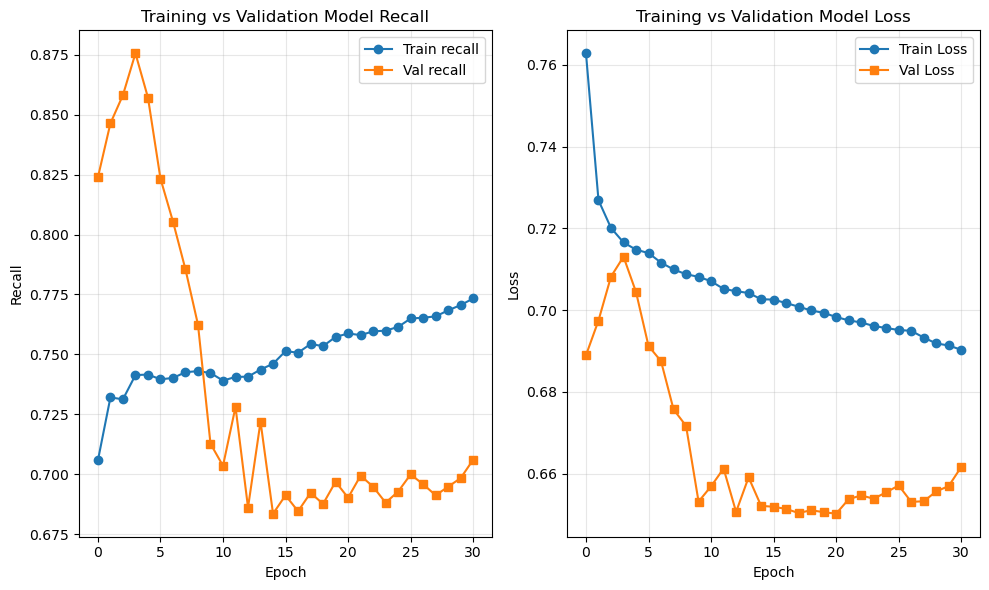

              precision    recall  f1-score   support

       False       0.76      0.55      0.64     15048
        True       0.49      0.72      0.58      9110

    accuracy                           0.61     24158
   macro avg       0.63      0.63      0.61     24158
weighted avg       0.66      0.61      0.62     24158



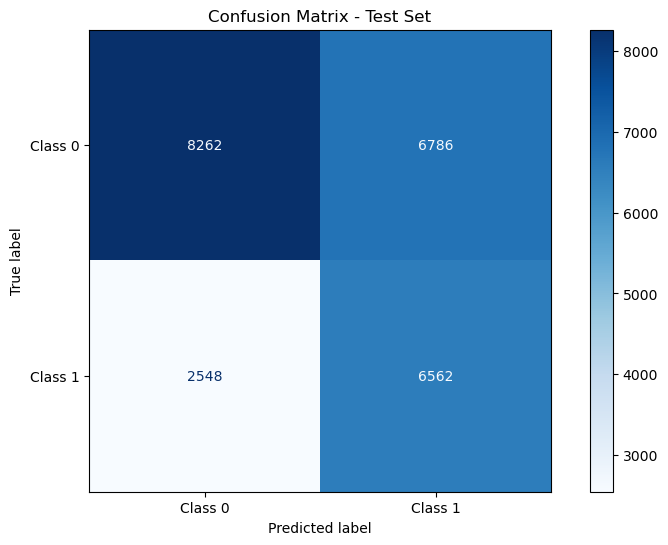

In [24]:
model, results = train_and_evaluate_recall(
    hidden_layer_sizes=[128, 64, 32],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.001,
    num_epochs=50,
    early_stopping=True,
    patience=10)

---

### VI. Evaluate the model on test data

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6860 - loss: 0.6459 - precision: 0.4958 - recall: 0.7259

MODEL RESULTS ON TEST DATA
Test Loss: 0.6459
Test Recall: 0.7259
Test Precision: 0.4958
Test AUC: 0.6860
Test F1: 0.5906


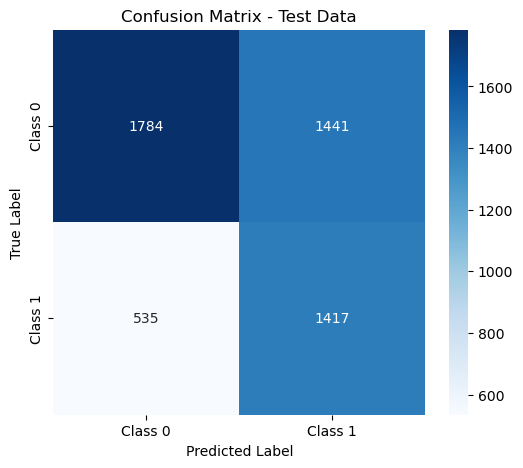

[[1784 1441]
 [ 535 1417]]


In [25]:
# evaluate on test set
results = model.evaluate(X_test, y_test)
test_loss = results[0]
test_recall = results[1]
test_precision = results[2]  
test_auc = results[3]
test_f1 = f1_score(y_test, y_test_pred)

# create predictions
y_test_pred_probs = model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

print('\nMODEL RESULTS ON TEST DATA')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test F1: {test_f1:.4f}\n\n')

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(cm)

### Subgroup Analysis

In [16]:
def subgroup_metrics(y_test, y_pred, name, n):
    return {
        'Subgroup': name, 
        'N': n,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0)
    }
y_test_pred_probs = model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

#### By Sex

In [18]:
sex_results = []
for val, name in [(0, 'Male'), (1, 'Female')]:
    mask = X_test['_SEX'] == val
    sex_results.append(subgroup_metrics(
        y_test[mask], 
        y_test_pred[mask], 
        name, 
        mask.sum()
    ))
sex_df = pd.DataFrame(sex_results)
print("Performance by Sex:")
print(sex_df.to_string(index=False))

Performance by Sex:
Subgroup    N  Accuracy  Precision   Recall       F1
    Male 2357  0.566398   0.518726 0.852158 0.644892
  Female 2820  0.639362   0.437903 0.629200 0.516405


#### By Age Group

In [20]:
age_bins = [(18, 30, '18-29'), (30, 45, '30-44'), (45, 60, '45-59'), (60, 100, '60+')]
age_results = []
for lo, hi, name in age_bins:
    mask = (X_test['_AGE80'] >= lo) & (X_test['_AGE80'] < hi)
    if mask.sum() > 0:
        age_results.append(subgroup_metrics(y_test[mask], y_test_pred[mask], name, mask.sum()))

age_df = pd.DataFrame(age_results)
print("Performance by Age Group:")
print(age_df.to_string(index=False))

Performance by Age Group:
Subgroup    N  Accuracy  Precision   Recall       F1
   18-29  512  0.593750   0.537688 0.899160 0.672956
   30-44  851  0.566392   0.517964 0.880407 0.652215
   45-59 1117  0.574754   0.489392 0.752174 0.592973
     60+ 2697  0.634038   0.449841 0.656214 0.533774


#### By Race

In [21]:
race_results = []

# white
white = (X_test['race_2.0']==0) & (X_test['race_3.0']==0) & (X_test['race_4.0']==0) & (X_test['race_5.0']==0) & (X_test['race_6.0']==0)
race_results.append(subgroup_metrics(y_test[white], y_test_pred[white], 'White', white.sum()))

# black
black = X_test['race_2.0'] == 1
if black.sum() > 0:
    race_results.append(subgroup_metrics(y_test[black], y_test_pred[black], 'Black', black.sum()))

# other
other = (X_test['race_3.0']==1) | (X_test['race_4.0']==1) | (X_test['race_5.0']==1) | (X_test['race_6.0']==1)
if other.sum() > 0:
    race_results.append(subgroup_metrics(y_test[other], y_test_pred[other], 'Other', other.sum()))

race_df = pd.DataFrame(race_results)
print("Performance by Race:")
print(race_df.to_string(index=False))

Performance by Race:
Subgroup    N  Accuracy  Precision   Recall       F1
   White 3092  0.580854   0.510529 0.813572 0.627372
   Black  542  0.612546   0.395833 0.593750 0.475000
   Other 1543  0.654569   0.437117 0.631929 0.516772


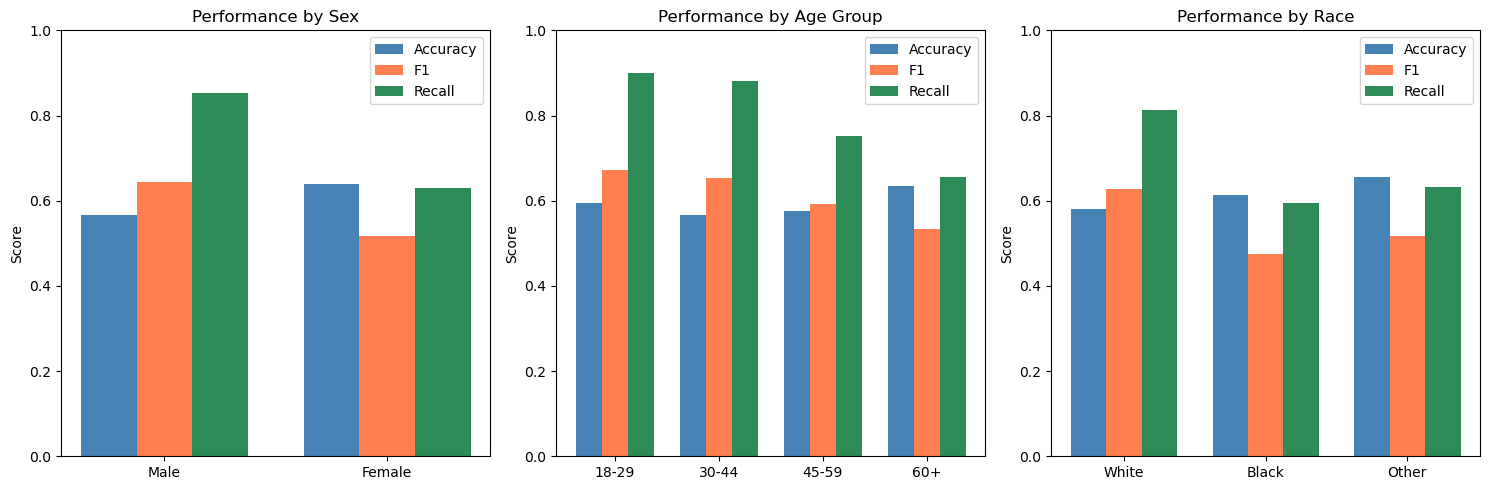

In [22]:
# visualize subgroup performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (df, title) in zip(axes, [(sex_df, 'Sex'), (age_df, 'Age Group'), (race_df, 'Race')]):
    x = np.arange(len(df))
    w = 0.25
    ax.bar(x - w, df['Accuracy'], w, label='Accuracy', color='steelblue')
    ax.bar(x, df['F1'], w, label='F1', color='coral')
    ax.bar(x + w, df['Recall'], w, label='Recall', color='seagreen')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Subgroup'])
    ax.set_ylabel('Score')
    ax.set_title(f'Performance by {title}')
    ax.legend()
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()